# Capstone

Michael Schillawski, 10 April 2018

Data Science Immersive, General Assembly

## Imports

In [1]:
import os
import json
import re
import string
import multiprocessing
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

from pandas.io.json import json_normalize
from joblib import Parallel, delayed
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
from ipywidgets import *

%matplotlib inline

os.getcwd()

'/Users/mjschillawski/Google Drive/Data/generalassembly/projects/GitHub Portfolio/capstone_project'

## Load Data

### Load Data From JSON

In [2]:
path = '/Users/mjschillawski/Desktop/Miscellaneous Data/Yummly28K/'
file = 'data_records_27638.txt'

data = pd.read_table(path+file,header=None,names=['recipe'],index_col=1)

In [3]:
path = '/Users/mjschillawski/Desktop/Miscellaneous Data/Yummly28K/metadata27638/'

recipes = []

for i in data.index:
    num = str(i)
    while len(num) < 5:
        num = '0' + num
        
    # https://stackoverflow.com/questions/28373282/how-to-read-a-json-dictionary-type-file-with-pandas
    with open(path+'meta'+num+'.json') as json_data:
        recipe = json.load(json_data)
        recipes.append(recipe)

recipes = json_normalize(recipes)

recipes.to_csv('assets/recipes_dataset.csv')

### Load Data From CSV

In [4]:
recipes = pd.read_csv('assets/recipes_dataset.csv',index_col=0)

# transform ingredient field back into list when importing from CSV
recipes['ingredientLines'] = recipes['ingredientLines'].apply(
    lambda x: [item for item in x.split('\'') if item not in ('\,','[',']',', ')])

recipes.head()

,attributes.course,attributes.cuisine,attributes.holiday,attribution.html,attribution.logo,attribution.text,attribution.url,cookTime,cookTimeInSeconds,flavors.Bitter,...,nutritionEstimates,prepTime,prepTimeInSeconds,rating,source.sourceDisplayName,source.sourceRecipeUrl,source.sourceSiteUrl,totalTime,totalTimeInSeconds,yield
0,['Side Dishes'],['Italian'],NaN,<a href='http://www.yummly.com/recipe/Mushroom...,http://static.yummly.com/api-logo.png,Mushroom Risotto recipes: information powered ...,http://www.yummly.com/recipe/Mushroom-risotto-...,NaN,NaN,NaN,...,"[{'attribute': 'FAT_KCAL', 'unit': {'name': 'c...",NaN,NaN,5,Skinnytaste,http://www.skinnytaste.com/2009/10/risotto-is-...,http://www.skinnytaste.com,30 minutes,1800.0,servings: 6
1,['Main Dishes'],['Barbecue'],NaN,<a href='http://www.yummly.com/recipe/Filipino...,http://static.yummly.com/api-logo.png,Filipino BBQ Pork Skewers recipes: information...,http://www.yummly.com/recipe/Filipino-bbq-pork...,NaN,NaN,0.8333,...,"[{'attribute': 'FAT_KCAL', 'unit': {'name': 'c...",NaN,NaN,5,Skinnytaste,http://www.skinnytaste.com/2008/08/filipino-bb...,http://www.skinnytaste.com,40 min,2400.0,NaN
2,['Main Dishes'],['Italian'],NaN,<a href='http://www.yummly.com/recipe/Mushroom...,http://static.yummly.com/api-logo.png,Mushroom and Roasted Garlic Risotto recipes: i...,http://www.yummly.com/recipe/Mushroom-and-Roas...,NaN,NaN,1.0000,...,"[{'attribute': 'FAT_KCAL', 'unit': {'name': 'c...",NaN,NaN,3,MyRecipes,http://www.myrecipes.com/recipe/mushroom-roast...,http://www.myrecipes.com,1 Hr 25 Min,5100.0,Serves 6 (serving size: about 1 cup)
3,['Side Dishes'],"['French', 'American']",NaN,<a href='http://www.yummly.com/recipe/Gratin-D...,http://static.yummly.com/api-logo.png,Gratin Dauphinois (Scalloped Potatoes with Che...,http://www.yummly.com/recipe/Gratin-Dauphinois...,NaN,NaN,0.6667,...,"[{'attribute': 'FAT_KCAL', 'unit': {'name': 'c...",NaN,NaN,4,MyRecipes,http://www.myrecipes.com/recipe/gratin-dauphin...,http://www.myrecipes.com,55 min,3300.0,7 servings (serving size: 1 cup)
4,['Main Dishes'],['Barbecue'],NaN,<a href='http://www.yummly.com/recipe/Deliciou...,http://static.yummly.com/api-logo.png,Delicious Grilled Hamburgers recipes: informat...,http://www.yummly.com/recipe/Delicious-Grilled...,10 Min,600.0,0.1667,...,"[{'attribute': 'FAT_KCAL', 'unit': {'name': 'c...",5 Min,300.0,4,AllRecipes,http://allrecipes.com/Recipe/delicious-grilled...,http://www.allrecipes.com,15 Min,900.0,3 servings


### Extract Features We Care About

In [5]:
short_recipes = recipes[['attributes.course','attributes.cuisine','name','ingredientLines']]
short_recipes.to_csv('assets/short_recipes.csv')

## Ingredient Processing

There are a number of components to this. Some are done on an individual, token level. Others are done across ingredients:

**Token**:

- Strip numbers (quantities)
- Strip embedded numbers
- Strip common measurements and their abbreviations
- Strip punctuation
- Strip preparation methods
- Create custom stop word dictionary and remove those words from ingredient list

**Ingredient-level**:

- Inventory a "typical" pantry for expected, common items
    - Fuzzy match pantry items against the ingredients
    - Eliminate those ingredients to reduce recipe complexity
- Vectorize ingredients and apply agglomerative clustering
    - Measure similiarity/closeness of ingredients based on how they're described
    - Replace vectors of ingredients with vectors of clusters in representing recipes

### Preprocessing

In [6]:
# multi-threaded
def multi_process_ingredients(recipes,join=1,
                              nondescript=0,drop_words=None,
                              pantry=0,pantry_items=None):
    # create the search patterns

    # import punctuation characters
    # to remove all punctuation
    punct = string.punctuation
    punct_pattern = r"[{}]".format(punct)

    # to remove all numbers
    number_pattern = r"\d+\s"

    # embedded numbers
    embed_num_pattern = r".\d+."
    
    # removed prep methods
    prep_pattern = r"[a-z]+ed"
    
    # strip pluralization
    plural_pattern = r"s\s"
    
    # strip -ly
    ly_pattern = r"[a-z]+ly"
    
    # strip lead number
    lead_pattern = r"\d+[a-z]+"
    lead_repl = r"[a-z]+"
    
    # trail number
    trail_pattern = r"[a-z]+\d+"
    trail_repl = r"[a-z]+"
    
    recipes_ingredients = []
    ingredients = []

    for item in recipes:

        # strip punctuation
        text = re.sub(punct_pattern," ",item)
        # strip standalone numbers
        text = re.sub(number_pattern,"",text)
        # strip embedded numbers
        text = re.sub(embed_num_pattern,"",text)
        # strip preparation methods
        text = re.sub(prep_pattern,"",text)
        # strip pluralization
        text = re.sub(plural_pattern," ",text)
        # strip ly
        text = re.sub(ly_pattern,"",text)
        # lead
        text = re.sub(lead_pattern,lead_repl,text)
        # trail
        text = re.sub(trail_pattern,trail_repl,text)

        # tokenize
        tokenizer = RegexpTokenizer(r'\w+')
        processed_text = tokenizer.tokenize(text)

        # remove stop words
        processed_text = [text.lower() for text in processed_text if text.lower() 
                          not in stopwords.words('english')]
        
        # minimum word length
        processed_text = [text for text in processed_text if len(text) > 2]

        # remove non-descript recipe words
        if nondescript == 1 and drop_words != None:
            processed_text = [text.lower() for text in processed_text if text.lower()
                             not in drop_words]

        # append all each list that to describe an ingredient of the recipe
        ingredients.append(processed_text)

    # joined space-separated strings
    # attach all modifiers that describe each ingredient (non-separated)
    clean_ingredients = [" ".join(word) for word in ingredients]
    
    # remove pantry items
    if pantry == 1 and pantry_items != None:
        clean_ingredients = [text.lower() for text in clean_ingredients if text.lower() not in pantry_items]

    # append all ingredients for each recipe
    recipes_ingredients.append(clean_ingredients)   
    
        
    if join == 0:
        pass
    else:
        recipes_ingredients = [" ".join(ingredient) for ingredient in recipes_ingredients]
    
    return recipes_ingredients

In [7]:
num_cores = multiprocessing.cpu_count()
inputs = tqdm(short_recipes['ingredientLines'])

if __name__ == "__main__":
    recipes = Parallel(n_jobs=num_cores)(delayed(multi_process_ingredients)(i) for i in inputs)
print(len(recipes))

100%|██████████| 27638/27638 [01:22<00:00, 333.43it/s]


27638


In [8]:
# 1 list of ingredients for each recipe
recipes = [" ".join(recipe) for recipe in recipes]
recipes = pd.DataFrame(recipes)

In [9]:
recipes.head()

,0
0,cup baby bella mushroom cup arborio rice tsp o...
1,pork country style rib fat cut cubes cup soy ...
2,whole garlic heads tablespoon plu teaspoon ext...
3,garlic clove cooking spray potatoe cut inch sl...
4,pound lean ground beef tablespoon worcestershi...


### Word Counts for Custom Stopword Dictionary

#### Get Counts of Words that Describe Ingredients

In [10]:
# word counts
# get the words that occur most often in recipes
# these are candidates for removal in order to simplify the axis that we compare recipes

cvec = CountVectorizer(strip_accents=ascii)
cvecdata = cvec.fit_transform(recipes[0])

cvec_dense  = pd.DataFrame(cvecdata.todense(),
             columns=cvec.get_feature_names())

word_count = cvec_dense.sum(axis=0)    
cw = word_count.sort_values(ascending = False)
print(cw[0:10])

cw_dict = dict(cw)

cup           76725
teaspoon      46142
tablespoon    40078
pepper        26446
salt          26439
fresh         22512
ounce         18745
ground        18002
oil           17914
garlic        13556
dtype: int64


#### Manually Evaluate Ingredient Word List to Build Dictionary

In [11]:
# quick function to manually evaluate words that ought to be removed
# https://stackoverflow.com/questions/5844672/delete-an-item-from-a-dictionary

def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

def eval_words(word_list):
    keeps = []
    nondescript = []
    
    nondescript_words = [] 
    keep_words = []
    
    for key,value in word_list.items():
            word_eval = input('Keep {}: {}, y or n?'.format(key,value))
        
            if word_eval == 'n':
                nondescript_words.append(key)
            else:
                keep_words.append(key)
            
            remaining_list = removekey(word_list,key)
            
            if len(nondescript_words) % 100 == 0:
                nondescript = nondescript + nondescript_words
                keeps = keeps + keep_words
                
                # empty holding lists
                keep_words = []
                nondescript_words = []
                
                prompt_continue = input('Continue: yes or no?')
                if prompt_continue == "yes":
                    pass
                else:
                    # export lists as pickles for recovery
                    # store outside the environment to limit reprocessing
                    words_lists = (keeps,nondescript,remaining_list)
                    names = ("keeps","nondescript","remaining")
                    for index,word in enumerate(words_lists):
                        with open("assets/"+names[index]+".pickle","wb") as file:
                            pickle.dump(word,file)
                    return keeps, nondescript,remaining_list
    
    # export word lists for recovery
    # so we don't have to do this multiple times
    words_lists = (keeps,nondescript,remaining_list)
    names = ("keeps","nondescript","remaining")
    for index,word in enumerate(words_lists):
        with open("assets/"+names[index]+".pickle","wb") as file:
            pickle.dump(word,file)
    
    return keep_words, nondescript_words, remaining_list

#### Load Pickled Keep/Drop Lists

In [12]:
# read in pickled results
keep_list = []
drop_list = []

names = ("_keeps","_nondescript")
for name in names:
    for index in range(6):
        with open("assets/"+str(index)+name+".pickle",'rb') as file_handle:
            if name == "_keeps":
                keep_list = keep_list + pickle.load(file_handle)
            elif name == "_nondescript":
                drop_list = drop_list + pickle.load(file_handle)

#### Fix Human Errors in Keep/Drop Lists

In [13]:
# fix human error from ingredient classifications

misclassed_words = ['dice','block','dipping','stems','liter','pestle','2lb','pad','addition','paleo',
                    'smaller','teaspoons','gf','meatles','anytime','xe4utet','almond','scallions',
                    'evoo','wing','non','meal','gala','escarole','nectarine','stuffing','ganache',
                    'speck','hefe','champignon','silver','blade','kabocha','goudak','lindt','quorn',
                    'choi','evoki','aioli','broil','drumette','tex','massamon','pao','steamer','dandelion',
                    'bonnet','rapini','cakes','yucatero','cheek','latin','jimmy','quahog','cone','durum',
                    'cornichons','banh','fryers','quantity','5tbsp','llime','chopping','spam','ink','plant',
                    'triangular','valencia','tubetti','tubettini','cavatelli','perhap','livers','bee',
                    'tartine','teacup','barlett','maker','xlour','jell','fat','free','package'
                   ]

for word in misclassed_words:
    if word in keep_list and word not in drop_list:
        drop_list.append(word)
        keep_list.remove(word)
        print('{} added to drop_list'.format(word))
    elif word in drop_list and word not in keep_list:
        keep_list.append(word)
        drop_list.remove(word)
        print('{} added to keep list'.format(word))
    elif word in drop_list and word in keep_list:
        print('! {} found on both lists !')
    elif word not in drop_list and word not in keep_list:
        print('! {} not found on either list ! You misspelled target word'.format(word))
    else:
        print('! Bigger problems !')

with open("assets/keep_list.pickle","wb") as file:
    pickle.dump(keep_list,file)
with open("assets/drop_list.pickle","wb") as file:
    pickle.dump(drop_list,file)

dice added to drop_list
block added to drop_list
dipping added to drop_list
stems added to drop_list
liter added to drop_list
pestle added to drop_list
2lb added to drop_list
pad added to keep list
addition added to drop_list
paleo added to drop_list
smaller added to drop_list
teaspoons added to drop_list
gf added to drop_list
meatles added to drop_list
anytime added to drop_list
xe4utet added to drop_list
almond added to keep list
scallions added to keep list
evoo added to keep list
wing added to keep list
non added to keep list
meal added to keep list
gala added to keep list
escarole added to keep list
nectarine added to keep list
stuffing added to keep list
ganache added to keep list
speck added to keep list
hefe added to keep list
champignon added to keep list
silver added to keep list
blade added to keep list
kabocha added to keep list
goudak added to keep list
lindt added to keep list
quorn added to keep list
choi added to keep list
! evoki not found on either list ! You misspell

We will feed this *drop_list* back into the preprocessing function to remove the non-descript words from the ingredient descriptions

### Identifying Ingredients in our Pantry

In [14]:
# re-process ingredient list, this time removing the non-descript words identified above
# getting data ready to identify similiarity with our pantry items

num_cores = multiprocessing.cpu_count()
inputs = tqdm(short_recipes['ingredientLines'])

if __name__ == "__main__":
    recipes_drops = Parallel(n_jobs=num_cores)(delayed(multi_process_ingredients)(i,join=0,
                                                                                  nondescript=1,
                                                                                  drop_words=drop_list
                                                                                 )
                                                                            for i in inputs)
print(len(recipes_drops))

100%|██████████| 27638/27638 [01:29<00:00, 310.43it/s]


27638


#### Pantry Items

I inventoried my kitchen to build a baseline set of ingredients we can expect to find in a kitchen.

These ingredients are matched to the master list of ingredients, using fuzzy matching, and matches are dropped out of the ingredient list to reduce dimensionality.

In [15]:
pantry = ['oregano','garlic powder','ground cumin','onion powder','ground mustard','hot hungarian paprika',
          'mexican oregano','smoked paprika','dill weed','ground turmeric','ground ginger','ground cloves',
         'cumin seed','cayenne pepper','chili powder','ground thyme','celery seed','curry powder',
          'ground white pepper','paprika','ground nutmeg','old bay','maple syrup','thyme leaves',
          'ground black pepper','black pepper','black peppercorns','crushed red pepper flakes','whole oregano',
         'minced onion','fennel seed','cinnamon','dried basil','anise seed','bay leaves','bay leaf',
          'ancho chili powder','ground cloves','coriander','vanilla extract','italian seasoning',
          'apple cider vinegar','honey','corn starch','balsamic vinegar','bread crumbs','white wine vinegar',
         'soy sauce','ketchup','tomato ketchup','red wine vinegar','vegatable oil','canola oil','sherry',
          'baking powder','baking soda','molasses','peanut butter','olive oil','extra virgin olive oil','salt',
          'sea salt','kosher salt','white vinegar','egg','eggs','egg whites','egg yolk','brown sugar','sugar',
          'flour','evoo','butter','salt pepper','garlic','garlic clove']

#### Pantry Processing

In [16]:
# this eliminates ingredients that have been wholly reduced to blanks
test = [[[ingredient for 
                   ingredient in recipe if ingredient != ''] 
                  for recipe in item] 
                 for item in recipes_drops]

# we're going to take all the ingredients from every recipe and string them together
# then take the set of that to find every unique ingredient

ingredient_master = []
for items in test:
    for recipe in items:
        ingredient_master = list(set(ingredient_master + recipe))
print(len(ingredient_master))

32983


In [17]:
# from the ingredient_master list, we eliminate ingredients that bear substantial similiarity to our pantry items
# because these ingredients are IN our pantry, they are not essential for determining overall recipe similiarity
# in fact, it gives us more degrees of freedom to find a match by increasing the range of possible flavor profiles
# of a related recipe -- because we go into the pantry and pull out different spices other than those in our target
# recipe
# this will fuzzy matching (ratio)

def match_pantry(ingredient_list,pantry_items=pantry,n_jobs=0):
    if n_jobs == 1:
        if ingredient_list in pantry_items:
            return ingredient_list
        else:
            for item in pantry_items:
                if fuzz.ratio(item,ingredient_list) > 70:
                    return ingredient_list
                    break
                else:
                    pass
    else:
        pantry_matches = []

        for ingredient in ingredient_list:
            if ingredient in pantry_items:
                pantry_matches.append(ingredient)
            else:
                for item in pantry_items:
                    if fuzz.ratio(item,ingredient) > 70:
                        pantry_matches.append(ingredient)
                        break
        return pantry_matches  

In [18]:
num_cores = multiprocessing.cpu_count()
inputs = tqdm(ingredient_master)

if __name__ == "__main__":
    pantry_matches = Parallel(n_jobs=num_cores)(delayed(match_pantry)(i,pantry,n_jobs=1) for i in inputs)
    
pantry_matches = [match for match in pantry_matches if match != None]

with open("assets/pantry_matches.pickle","wb") as file:
    pickle.dump(pantry_matches,file)

100%|██████████| 32983/32983 [00:03<00:00, 8757.32it/s]


### Reducing Ingredient Dimensionality

After doing all the above preprocessing steps on the ingredients, we still need to reduce the dimensionality of the ingredients that describe the recipes in the cookbook.

My solution is to take the list of each unique ingredient, CountVectorize them, and feed them into an agglomerative clustering algorithm. 

With our cluster assignments, we will replace ingredients to be represented by the cluster that they belong to. Our recipes will now be able to be represented as a vector of clusters instead a vector of ingredients.

The dimensionality of ingredient will have then been reduced, and we can move into the recipe recommender and measuring the similiarity between recipes.

In [19]:
# re-process ingredient list, this time removing the non-descript words and pantry items as identified above
# getting data ready for clustering

num_cores = multiprocessing.cpu_count()
inputs = tqdm(short_recipes['ingredientLines'])

if __name__ == "__main__":
    cookbook = Parallel(n_jobs=num_cores)(delayed(multi_process_ingredients)(i,join=0,
                                                                                  nondescript=1,
                                                                                  drop_words=drop_list,
                                                                                  pantry=1,
                                                                                  pantry_items=pantry_matches
                                                                                 )
                                                                            for i in inputs)

100%|██████████| 27638/27638 [01:36<00:00, 286.42it/s]


In [20]:
# this eliminates ingredients that have been wholly reduced to blanks
test = [[[ingredient for 
                   ingredient in recipe if ingredient != ''] 
                  for recipe in item] 
                 for item in cookbook]

# we're going to take all the ingredients from every recipe and string them together
# then take the set of that to find every unique ingredient
ingredient_master = []
for items in test:
    for recipe in items:
        ingredient_master = list(set(ingredient_master + recipe))
print(len(ingredient_master))

31266


#### Vectorize Ingredients

In [21]:
ingredient_master_cvector = CountVectorizer(strip_accents=ascii)
ingredient_master_cvectordata = ingredient_master_cvector.fit_transform(ingredient_master)

ingredient_master_cvector_dense  = pd.DataFrame(ingredient_master_cvectordata.todense(),
             columns=ingredient_master_cvector.get_feature_names())

ingredient_master_cvector_dense.shape

(31266, 7265)

#### Agglomerative Clustering of Vectorized Ingredients

In [22]:
# from 8.04 Hierarchical Clustering Lesson

def plot_dendogram(df):
    
    # Data preparation:
    X = df.values
    Z = linkage(X, 'ward')
    
    # Plotting:
    plt.title('Dendrogram')
    plt.xlabel('Index Numbers')
    plt.ylabel('Distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  
        leaf_font_size=8.,
    )
    plt.show()
    
    
#plot_dendogram(ingredient_master_cvector_dense)

In [23]:
X = ingredient_master_cvector_dense.values
Z = linkage(X, 'ward')

clusters = fcluster(Z,5.5, criterion='distance')

with open("assets/clusters.pickle","wb") as file:
    pickle.dump(clusters,file)

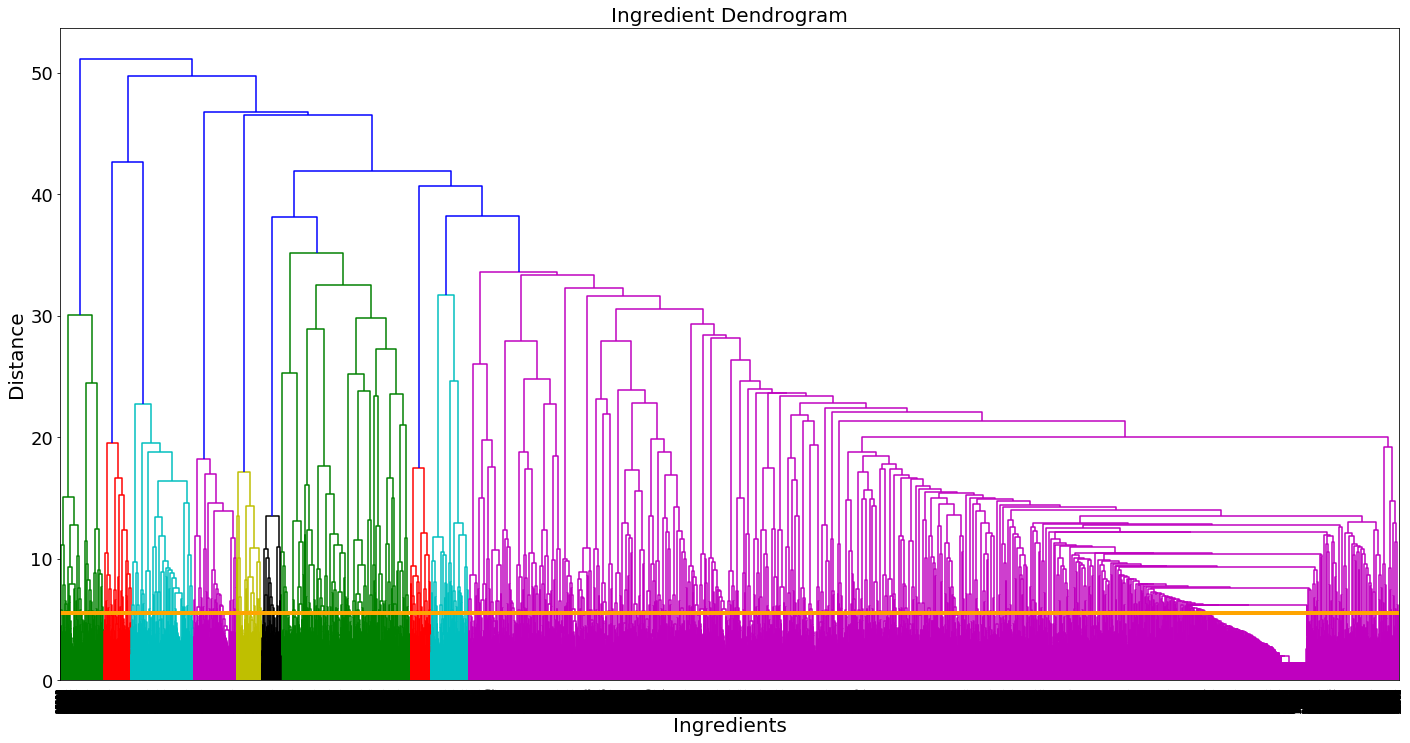

In [51]:
plt.figure(figsize=(24,12))
plt.title('Ingredient Dendrogram',fontsize=20)
dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=8.,
    )
plt.xlabel('Ingredients',fontsize=20)
#https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot
plt.ylabel('Distance',fontsize=20)
plt.yticks(fontsize=18)
plt.axhline(5.5,color='orange',linewidth=4)
plt.show()

In [25]:
with open ("assets/clusters.pickle","rb") as file:
    clusters = pickle.load(file)

In [26]:
clusters.max()

607

### Represent Recipes as Vectors of Clusters, Instead of Vectors of Ingredients

In [27]:
ingredient_master_cvector_dense['clusters'] = clusters

In [28]:
ingredient_clusters = pd.DataFrame(ingredient_master,clusters)
ingredient_clusters.reset_index(inplace=True)
ingredient_clusters.rename(columns={'index':'ingredient cluster',0:'ingredient'},inplace=True)
ingredient_clusters.set_index('ingredient',inplace=True)

In [29]:
# reduce extra layer in cookbook
new_cookbook = []
for chapter in cookbook:
    for recipe in chapter:
        new_cookbook.append(recipe)
cookbook = new_cookbook

In [30]:
# this eliminates ingredients that have been wholly reduced to blanks
cookbook = [[ingredient for 
                   ingredient in recipe if ingredient != ''] 
                  for recipe in cookbook]

In [31]:
def cluster_vectors(recipe):
    cv_recipe = [ingredient_clusters.at[ingredient,'ingredient cluster'] for ingredient in recipe]
    return cv_recipe

In [32]:
# re-process ingredient list, this time removing the non-descript words identified above
# getting data ready for recommender

num_cores = multiprocessing.cpu_count()
inputs = tqdm(cookbook)

if __name__ == "__main__":
    cv_cookbook = Parallel(n_jobs=num_cores)(delayed(cluster_vectors)(i) for i in inputs)

100%|██████████| 27638/27638 [00:02<00:00, 12387.68it/s]


## Recommender

### Prep Data for Recommender

In [33]:
cv_recipes = pd.DataFrame(index=np.arange(len(cv_cookbook)),columns=np.arange(clusters.max()))

In [34]:
for index,cv_recipe in enumerate(cv_cookbook):
    for cv_ingredient in cv_recipe:
        cv_recipes.at[index,cv_ingredient] = 1
cv_recipes.fillna(0,inplace=True)

### Recommender

In [35]:
def mean_center_rows(df):
    return (df.T - df.mean(axis=1)).T

In [52]:
recipes_mc = mean_center_rows(cv_recipes)

# check for nulls
print('nulls: {}'.format(recipes_mc.isnull().sum().sum()))

nulls: 0


In [64]:
sim_matrix = cosine_similarity(recipes_mc)
recipe_sim = pd.DataFrame(sim_matrix, columns=short_recipes.name, index=short_recipes.name)

In [ ]:
recipe_sim.to_csv('assets/recipe_sim.csv')

In [ ]:
recipe_sim

In [177]:
def recommender(recipe,max_thresh=0.9):
    ingredients = list(short_recipes[short_recipes['name']==recipe]['ingredientLines'])
    ingredients = [item for ingredient in ingredients for item in ingredient]
    
    match = recipe_sim[recipe].sort_values(ascending=False)[1:5]
    for m in match:
        if m <= max_thresh:
            best_match = match[match==m].index[0]
            similarity = m
            break
    
    needs = list(short_recipes[short_recipes['name']==best_match]['ingredientLines'])
    needs = [item for need in needs for item in need]
    
    print('I recommend {}, with a similarity of {:3f}\n'.format(best_match,similarity))
    print('\nFor {}, you need:\n'.format(recipe))
    for ingredient in ingredients:
        print(ingredient)
    
    print('\nFor {}, you need:\n'.format(best_match))
    for need in needs:
        print(need)
    return None

In [181]:
recommender('Marinated Beef Tenderloin')

For Marinated Beef Tenderloin, you need:

1 beef tenderloin (3 pounds; preferably center-cut), silver skin trimmed
1/4 cup Worcestershire sauce
Juice of 1 lemon
2 tablespoons finely chopped garlic
2 teaspoons coarse salt
2 teaspoons coarsely ground pepper
1 teaspoon safflower oil
1/2 stick unsalted butter, softened, divided

For Bison Tenderloin Marinated in Roasted Garlic and Cracked Peppercorns, you need:

7 whole ears of garlic
2 tbsp peppercorns
¼ cup Worcestershire sauce
salt and black pepper
salt and black pepper
a little olive oil
3-4lb bison (or beef) tenderloin
